In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data

import numpy as np
import pandas as pd
import xarray as xr
import bottleneck as bn
import iris

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix

In [2]:
# Save filepaths
plotdir = '/g/data/w97/mg5624/plots/RF_project/model_analytics/'
datadir = '/g/data/w97/mg5624/RF_project/'

# Train Both Random Forest Models

## Load Training Data

In [25]:
training_data = pd.read_csv(datadir + 'training_data/training_data.csv')
training_data.dropna(axis=0, inplace=True)

predictors_precip = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation', 
                     'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation', 'Acc_48-Month_Precipitation', 'Runoff', 
                     'ENSO_index', 'IOD_index', 'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month']

# predictors with all variables
predictors_full = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation', 
                   'Acc_24-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index', 'SAM_index', 'ET', 'PET', 'SMsurf', 
                   'SMroot', 'Sin_month', 'Cos_month']


# predictors of variables with timeseries back to 1950 or ealier (these go back to at least 1911)
predictors_long_ts = ['Precipitation', 'Acc_3-Month_Precipitation', 'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation', 
                      'Acc_24-Month_Precipitation', 'Acc_12-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index', 
                      'Sin_month', 'Cos_month']

variable_to_label = {
    'Precipitation': 'Precipitation',
    'Acc_3-Month_Precipitation': '3-Month Precipitation',
    'Acc_6-Month_Precipitation': '6-Month Precipitation',
    'Acc_12-Month_Precipitation': '12-Month Precipitation',
    'Acc_24-Month_Precipitation': '24-Month Precipitation',
    'Runoff': 'Runoff',
    'ENSO_index': 'ENSO',
    'IOD_index': 'IOD',
    'SAM_index': 'SAM',
    'ET': 'ET',
    'PET': 'PET',
    'SMsurf': 'Surface SM',
    'SMroot': 'Root SM',
    'Sin_month': 'Sine of Month',
    'Cos_month': 'Cosine of Month',
}
    
target = 'Drought'

model_types = [
    # '1980',
    # '1911',
    'precip',
]

model_title = {
        "full": "Full",
        "long_ts": "Long TS",
        "precip": "Precipitation",
    }

predictors_dict = {
    '1980': predictors_full,
    '1911': predictors_long_ts,
    'precip': predictors_precip,
}

y = training_data['Drought']

## Check Dataset is Balanced

In [4]:
def check_if_dataset_is_balanced(data, target, balanced_threshold):
    """
    Checks if the data has balanced drought and no drought targets.
    Args:
    data (pd.DataFrame): Contains all training data
    target (str): name of the target variable ('Drought')
    balanced_threshold (float): threshold for imbalance (e.g. 0.1)
    """
    y = data[target]
    
    class_counts = y.value_counts()
    
    class_proportions = class_counts / len(y)
    
    print("Class counts:\n", class_counts)
    print("\nClass proportions:\n", class_proportions)
    
    # Check if the dataset is balanced
    is_balanced = np.all(np.abs(class_proportions - 0.5) <= balanced_threshold)
    
    if is_balanced:
        print("\nThe dataset is balanced.")
    else:
        print("\nThe dataset is imbalanced.")

check_if_dataset_is_balanced(training_data, target, 0.1)

Class counts:
 Drought
1    515
0    420
Name: count, dtype: int64

Class proportions:
 Drought
1    0.550802
0    0.449198
Name: count, dtype: float64

The dataset is balanced.


## Train Model

In [5]:
def train_RF_model(data, predictors, target, test_size, random_seed, n_estimators, testing=True):
    """
    Trains a random forest model.
    Args:
        data (pd.DataFrame): Contains all training data
        predictors (list): list of strings of the names of the predictor variables
        target (str): name of the target variable ('Drought')
        test_size (float): proportion of the data to keep back fro testing
        random_seed (int): random seed value for the RF model
        n_estimators (int): number of estimators to builid RF model with
        testing (bool): if wanting to test model as well set testing=True, 
                        if testing=False, test_size will be set to zero

    Returns:
        clf (sk-learn.RandomForestClassifier): trained random forest classifier

        if testing:
            y_test: the target data held back fro testing
            y_pred: the predicted y data from running the model with the predictor test variables
    """        
    X = data[predictors]
    y = data[target]

    if testing:
        # Split the training_data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    else:
        X_train = X
        y_train = y
        
    # Create and train the Random Forest model
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_seed)
    clf.fit(X_train, y_train)

    if testing:
        y_pred = clf.predict(X_test)
        return clf, y_test, y_pred, X
    else:
        return clf

# clf_long_ts = RandomForestClassifier(n_estimators=500, random_state=42)
# clf_long_ts.fit(X_train_long_ts, y_train_long_ts)

# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.3, random_state=42)
# X_train_long_ts, X_test_long_ts, y_train_long_ts, y_test_long_ts = train_test_split(X_long_ts, y, test_size=0.3, random_state=42)

clf_full, y_test_full, y_pred_full, X_full = train_RF_model(training_data, predictors_full, target, 0.3, 42, 500)
clf_long_ts, y_test_long_ts, y_pred_long_ts, X_long_ts = train_RF_model(training_data, predictors_long_ts, target, 0.3, 42, 500)

clf_precip, y_test_precip, y_pred_precip, X_precip = train_RF_model(training_data, predictors_precip, target, 0.3, 42, 500)

## Compare Both Models

In [6]:
# Create an array of agreement between the two models
agree = y_pred_full == y_pred_long_ts
                                
# Display y_pred array
print("Predicted classes for the test data of the full model:\n", y_pred_full)
print("\nPredicted classes for the test data of the long timeseries model:\n", y_pred_long_ts)
print("\nPredicted agreement between the two models:\n:", agree)

# Calculate the number of droughts and non-droughts in y_pred
drought_count_full = np.sum(y_pred_full == 1)
non_drought_count_full = np.sum(y_pred_full == 0)

drought_count_long_ts = np.sum(y_pred_long_ts == 1)
non_drought_count_long_ts = np.sum(y_pred_long_ts == 0)

agreement_count = np.sum(agree == True)
disagreement_count = np.sum(agree == False)

print(f"\nNumber of predicted droughts in full model: {drought_count_full}")
print(f"Number of predicted non-droughts in full model: {non_drought_count_full}")

print(f"\nNumber of predicted droughts in long timeseries model: {drought_count_long_ts}")
print(f"Number of predicted non-droughts in long timeseires model: {non_drought_count_long_ts}")

print(f"\nNumber of events on which the two models agree: {agreement_count}")
print(f"Number of events on which the two models disagree: {disagreement_count}")

Predicted classes for the test data of the full model:
 [1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0]

Predicted classes for the test data of the long timeseries model:
 [1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 

## Evaluating Models

In [7]:
def calculate_performance_metrics(y_test, y_pred):
    """
    Calculates performance metrics from the RF model
    Args:
    y_test: Data held back from data split for testing
    y_pred: Prediction made by RF Classifier model
    """
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='all')
    false_alarm = confusion_matrix[0, 1]
    
    # Save results in DataFrame
    performance_data = {
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Balance Accuracy': [balanced_accuracy],
        'False Alarm': [false_alarm]
    }

    performance_df = pd.DataFrame(performance_data)
    
    return performance_df

performance_df_full = calculate_performance_metrics(y_test_full, y_pred_full)
performance_df_long_ts = calculate_performance_metrics(y_test_long_ts, y_pred_long_ts)

performance_df_precip = calculate_performance_metrics(y_test_precip, y_pred_precip)

print(f"Performance metrics for the full model are: \n{performance_df_full}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts}")

Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy  False Alarm
0  0.911032   0.885057  0.968553  0.924925           0.90231     0.071174

 Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy  False Alarm
0  0.914591   0.890173  0.968553  0.927711          0.906408     0.067616


In [8]:
# See what the scores are like for another random_state
clf_full2, y_test_full2, y_pred_full2, Xfull2 = train_RF_model(training_data, predictors_full, target, 0.3, 84, 500)
clf_long_ts2, y_test_long_ts2, y_pred_long_ts2, X_long_ts2 = train_RF_model(training_data, predictors_long_ts, target, 0.3, 84, 500)

performance_df_full2 = calculate_performance_metrics(y_test_full2, y_pred_full2)
performance_df_long_ts2 = calculate_performance_metrics(y_test_long_ts2, y_pred_long_ts2)

print(f"Performance metrics for the full model are: \n{performance_df_full2}")
print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts2}")

Performance metrics for the full model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy  False Alarm
0  0.935943   0.898204  0.993377  0.943396          0.931304     0.060498

 Performance metrics for the long timeseires model are: 
   Accuracy  Precision    Recall  F1-Score  Balance Accuracy  False Alarm
0  0.921708   0.895706  0.966887  0.929936          0.918059     0.060498


In [21]:
def create_performance_metric_bar_chart(performance_df, random_seed, model_type):
    """
    Creates a bar chart plot of the performance metrics for the model type specified.

    Args:
        performance_df (pd.DataFrame): performance metrics stored in a dataframe
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
        modle_type (str): the model type the performance metrics are for, either 'full', 'long_ts', or 'precip'
    """
    performance_df = performance_df.T
    ax = performance_df.plot(kind='bar', figsize=(12, 6), legend=False)
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'{model_type} Model Performance Metric for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 3), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'{model_type}_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'{model_type}_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

# create_performance_metric_bar_chart(performance_df_precip, 42, 'precip')

                      1980      1911
Accuracy          0.911032  0.914591
Precision         0.885057  0.890173
Recall            0.968553  0.968553
F1-Score          0.924925  0.927711
Balance Accuracy  0.902310  0.906408
False Alarm       0.071174  0.067616
full_vs_long_ts_model_performance_metrics_for_seed42.png


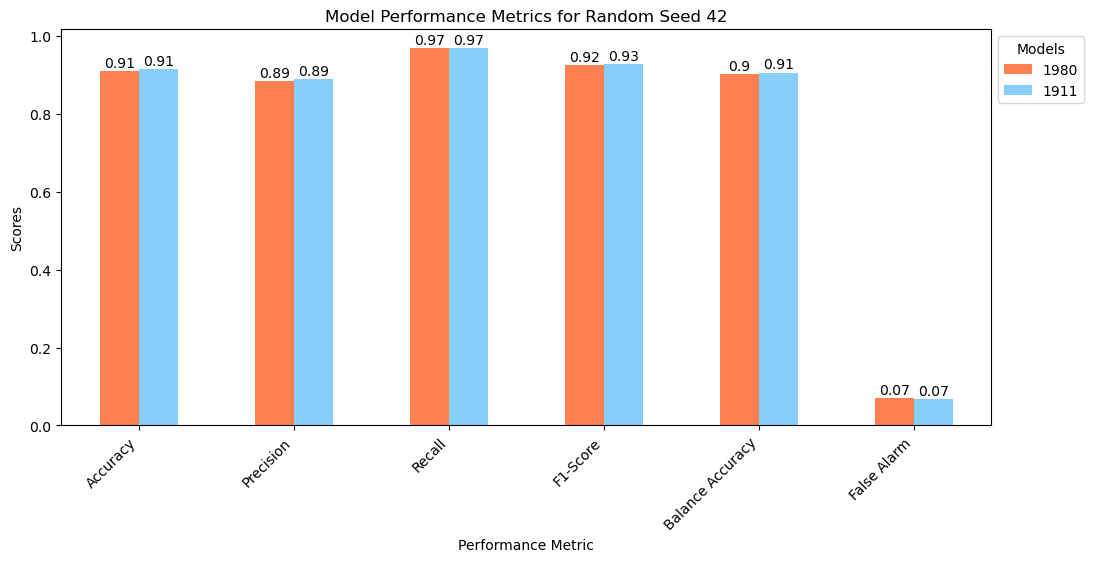

                      1980      1911
Accuracy          0.935943  0.921708
Precision         0.898204  0.895706
Recall            0.993377  0.966887
F1-Score          0.943396  0.929936
Balance Accuracy  0.931304  0.918059
False Alarm       0.060498  0.060498
full_vs_long_ts_model_performance_metrics_for_seed84.png


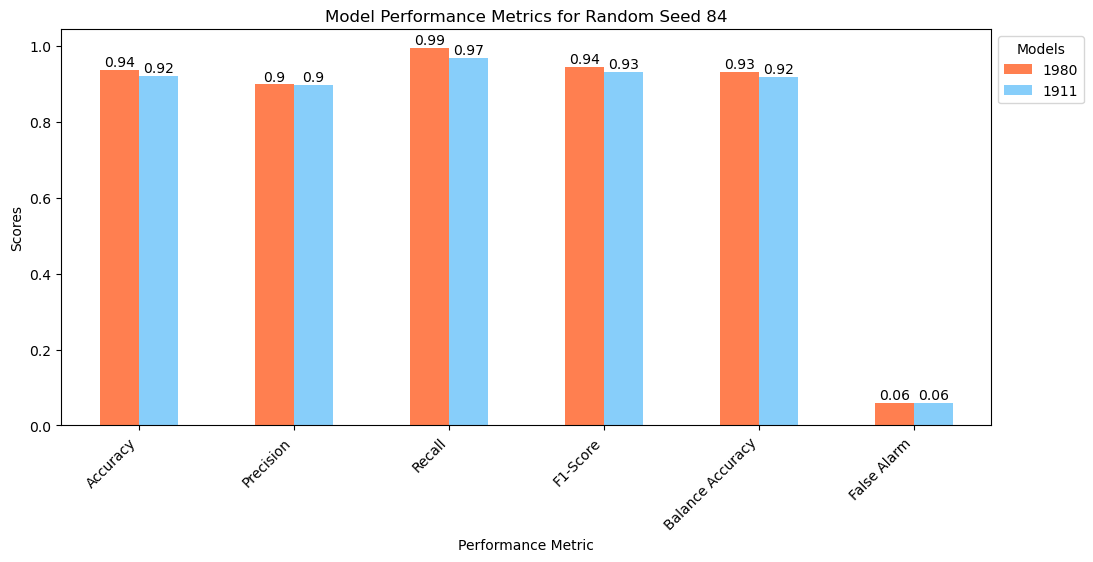

In [10]:
def create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, random_seed
):
    """
    Creates a bar plot to compare the performance metrics of the full model and
    long timeseries model.
    
    Args:
        performance_df_full (pd.DataFrame): the performance metrics for the full model
        performance_df_long_ts (pd.DataFrame): the performance metrics for the long timeseries model
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
    """
    # Create a barplot comparing the scores of the two models
    performance_frames = [performance_df_full, performance_df_long_ts]
    concat_performance_df = pd.concat(performance_frames)
    
    concat_performance_df.index = ['1980', '1911']
    concat_performance_df = concat_performance_df.T
    print(concat_performance_df)
    
    ax = concat_performance_df.plot(kind='bar', figsize=(12, 6), 
                                    color=['coral', 'lightskyblue'])
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'Model Performance Metrics for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)
    plt.legend(title='Models', loc='upper left', bbox_to_anchor=(1.0, 1.0))

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'full_vs_long_ts_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'full_vs_long_ts_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full, performance_df_long_ts, 42
)

create_bar_chart_full_vs_long_ts_performance_metrics(
    performance_df_full2, performance_df_long_ts2, 84
)

                      Full   Long TS    Precip
Accuracy          0.911032  0.914591  0.911032
Precision         0.885057  0.890173  0.880682
Recall            0.968553  0.968553  0.974843
F1-Score          0.924925  0.927711  0.925373
Balance Accuracy  0.902310  0.906408  0.901356
False Alarm       0.071174  0.067616  0.074733
full_vs_long_ts_vs_precip_model_performance_metrics_for_seed84.png


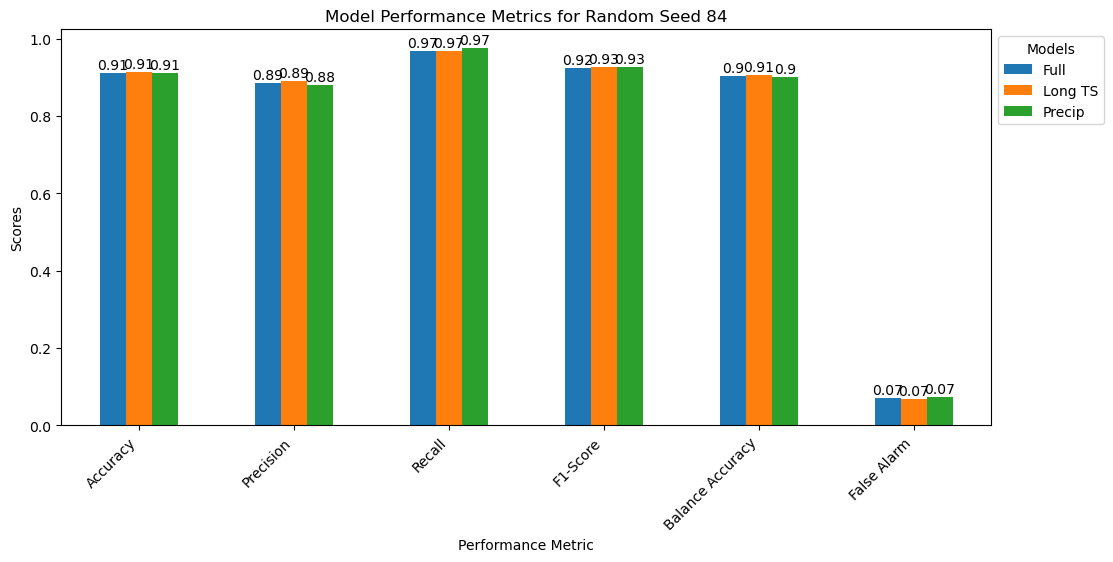

In [11]:
def create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(
    performance_df_full, performance_df_long_ts, performance_df_precip, random_seed
):
    """
    Creates a bar plot to compare the performance metrics of the full model and
    long timeseries model.
    
    Args:
        performance_df_full (pd.DataFrame): the performance metrics for the full model
        performance_df_long_ts (pd.DataFrame): the performance metrics for the long timeseries model
        random_seed (int or str):  if performance metrics from one random_seed then integer value of that seed,
        if performance metrics are averaged from many random_seeds then "average_score"
    """
    # Create a barplot comparing the scores of the two models
    performance_frames = [performance_df_full, performance_df_long_ts, performance_df_precip]
    concat_performance_df = pd.concat(performance_frames)
    
    concat_performance_df.index = ['Full', 'Long TS', 'Precip']
    concat_performance_df = concat_performance_df.T
    print(concat_performance_df)
    
    ax = concat_performance_df.plot(kind='bar', figsize=(12, 6))
    ax.figure.subplots_adjust(bottom=0.22)
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'Average Scores of Multiple Iterations'
    plt.title(f'Model Performance Metrics for {random_seed_title}')
    plt.xlabel('Performance Metric')
    plt.ylabel('Scores')
    plt.xticks(ha='right', rotation=45)
    plt.legend(title='Models', loc='upper left', bbox_to_anchor=(1.0, 1.0))

    # Add labels on top of each bar
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center')

    # Save figure
    figpath = plotdir + '/performance_metrics/'
    if isinstance(random_seed, int):
        figname = f'full_vs_long_ts_vs_precip_model_performance_metrics_for_seed{random_seed}.png'
    else:
        figname = f'full_vs_long_ts_vs_precip_model_performance_metrics_{random_seed}.png'

    print(figname)
    plt.savefig(figpath + figname)
    plt.show()

create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(performance_df_full, performance_df_long_ts, performance_df_precip, 84)

## Variable Importance

Variable Importances for full model:
 [0.03051328 0.06701787 0.07996757 0.11169741 0.07777128 0.03166939
 0.23729772 0.04978387 0.0921081  0.05578008 0.04625296 0.03280906
 0.03686316 0.02322343 0.02724482]

Negative Importance Indicators in full model:
 [False False False False False False False False False False False False
 False False False]

Variable Importances for long timeseries model:
 [0.03051328 0.06701787 0.07996757 0.11169741 0.07777128 0.03166939
 0.23729772 0.04978387 0.0921081  0.05578008 0.04625296 0.03280906
 0.03686316 0.02322343 0.02724482]

Negative Importance Indicators in long timeseries model:
 [False False False False False False False False False False False False
 False False False]


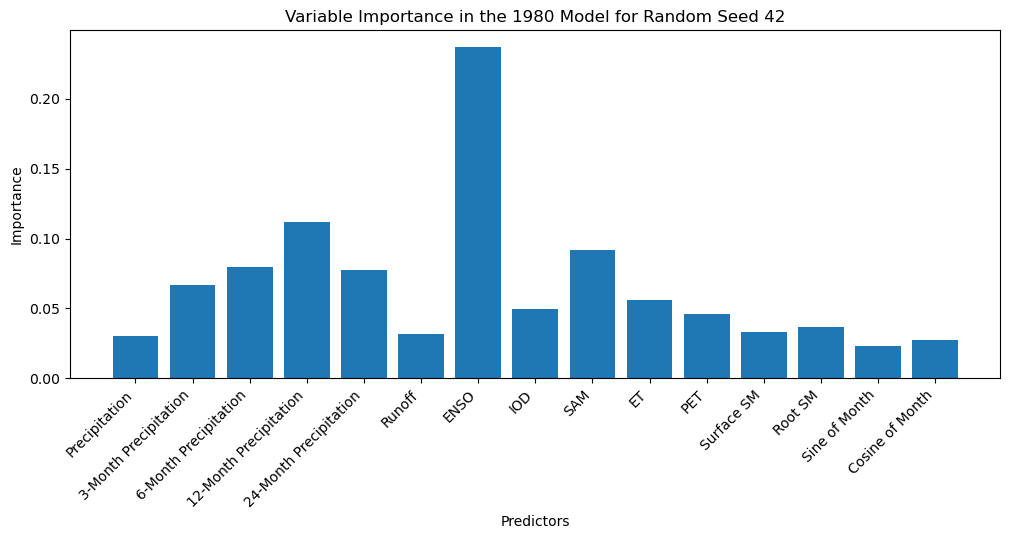

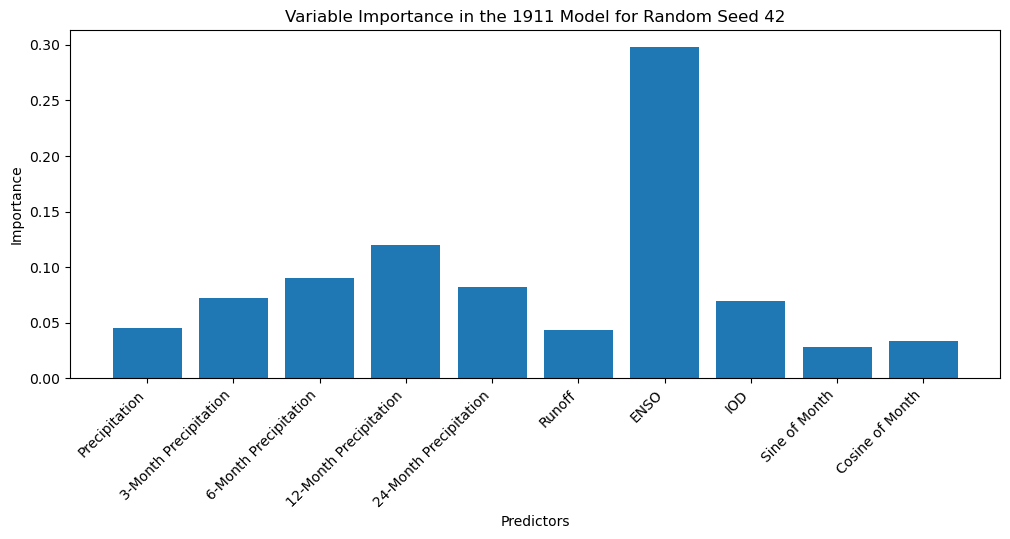

Ranking of predictors based on variable importance for full model:
                     Predictor  Variable Importance  Rank
0                   ENSO_index             0.237298     1
1   Acc_12-Month_Precipitation             0.111697     2
2                    SAM_index             0.092108     3
3    Acc_6-Month_Precipitation             0.079968     4
4   Acc_24-Month_Precipitation             0.077771     5
5    Acc_3-Month_Precipitation             0.067018     6
6                           ET             0.055780     7
7                    IOD_index             0.049784     8
8                          PET             0.046253     9
9                       SMroot             0.036863    10
10                      SMsurf             0.032809    11
11                      Runoff             0.031669    12
12               Precipitation             0.030513    13
13                   Cos_month             0.027245    14
14                   Sin_month             0.023223    15

Rank

In [19]:
# Calculate variable importance using the Random Forest model
variable_importance_full = clf_full.feature_importances_
variable_importance_long_ts = clf_long_ts.feature_importances_

variable_importance_precip = clf_precip.feature_importances_

# Check if any variable importances are negative
negative_importance_full = variable_importance_full < 0
negative_importance_long_ts = variable_importance_long_ts < 0

# Display variable importances and negative importance indicators
print("Variable Importances for full model:\n", variable_importance_full)
print("\nNegative Importance Indicators in full model:\n", negative_importance_full)

print("\nVariable Importances for long timeseries model:\n", variable_importance_full)
print("\nNegative Importance Indicators in long timeseries model:\n", negative_importance_full)


def create_variable_importance_barchart(variable_importance, X, model_type, random_seed):
    """
    Plots barchart indicating each variables importances in the model
    Args:
    variable_importance (np.array): importance of each variable
    X: predictor variables
    model_type (str): either "full" or "long_ts"
    random_seed (int): random state of the RF model
    """
    # Create a bar graph of variable importances
    ax = plt.figure(figsize=(12, 6))
    ax.figure.subplots_adjust(bottom=0.3)
    x_labels = [variable_to_label[var_name] for var_name in X.columns]
    plt.bar(x_labels, variable_importance)
    plt.xticks(ha='right', rotation=45)
    plt.xlabel('Predictors')
    plt.ylabel('Importance')
    if isinstance(random_seed, int):
        random_seed_title = f'Random Seed {random_seed}'
    else:
        random_seed_title = f'the Average of Multiple Iterations'
    plt.title(f'Variable Importance in the {model_type} Model for {random_seed_title}')
    figpath = plotdir + '/variable_importance/'
    figname = f'variable_importance_{model_type}_var_model_seed{random_seed}.png'
    plt.savefig(figpath + figname)
    plt.show()

create_variable_importance_barchart(variable_importance_full, X_full, '1980', 42)
create_variable_importance_barchart(variable_importance_long_ts, X_long_ts, '1911', 42)

# create_variable_importance_barchart(variable_importance_precip, X_precip, 'precip', 42)

# To display the ranking of the predictors
# Get the indices that would sort the variable importance array in descending order
sorted_indices_full = np.argsort(variable_importance_full)[::-1]
sorted_indices_long_ts = np.argsort(variable_importance_long_ts)[::-1]

# Create a DataFrame to display predictors and their rankings
ranking_df_full = pd.DataFrame({
    'Predictor': X_full.columns[sorted_indices_full],
    'Variable Importance': variable_importance_full[sorted_indices_full],
    'Rank': np.arange(1, len(X_full.columns) + 1)
})

ranking_df_long_ts = pd.DataFrame({
    'Predictor': X_long_ts.columns[sorted_indices_long_ts],
    'Variable Importance': variable_importance_long_ts[sorted_indices_long_ts],
    'Rank': np.arange(1, len(X_long_ts.columns) + 1)
})

# Print the ranking of predictors based on variable importance
print("Ranking of predictors based on variable importance for full model:")
print(ranking_df_full)

print("\nRanking of predictors based on variable importance for long timeseries model:")
print(ranking_df_long_ts)

## Multiple Iterations

In [13]:
def performance_and_variable_importance_from_n_iterated_RF_model_seeds(X, y, test_size, n_iterations=100):
    """
    Trains the Random Forest with different seeds to assess stability and generalisability of the model.
    Args:
    X: predictor variables data
    y: target variables data
    test_size (float): proportion of data to be held back for testing
    n_iterations (int): number of iterations of model (default=100)
    """
    seeds = np.arange(n_iterations)

    # Initialize arrays to store variable importance
    variable_importance = np.zeros((len(X.columns), n_iterations))

    # Initialize arrays to store performance metrics
    accuracy_scores = np.zeros(n_iterations)
    precision_scores = np.zeros(n_iterations)
    recall_scores = np.zeros(n_iterations)
    f1_scores = np.zeros(n_iterations)
    balanced_accuracy_scores = np.zeros(n_iterations)

    # Train the model and calculate performance metrics for each iteration
    for i, seed in enumerate(seeds):
        # Split the data into training and testing sets for each iteration
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
        # Train the Random Forest model with a different seed
        clf = RandomForestClassifier(n_estimators=500, random_state=seed)
        clf.fit(X_train, y_train)

        # Calculate variable importance
        variable_importance[:, i] = clf.feature_importances_
        
        # Predict on test data
        y_pred = clf.predict(X_test)
    
        # Calculate performance metrics
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred)
        recall_scores[i] = recall_score(y_test, y_pred)
        f1_scores[i] = f1_score(y_test, y_pred)
        balanced_accuracy_scores[i] = balanced_accuracy_score(y_test, y_pred)
        
    # Create a DataFrame to store the performance metrics for each iteration
    performance_df = pd.DataFrame({
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-score': f1_scores,
        'Balanced Accuracy': balanced_accuracy_scores
    })
    print('\n', performance_df)

    variable_importance_df = pd.DataFrame(variable_importance.T, columns=X.columns)
    
    return performance_df, variable_importance_df


def find_mean_performance_metrics_and_var_importance(performance_df, variable_importance_df):
    """
    Find the mean of each performance metric.
    Args:
    performance_df (pd.DataFrame): 
        dataframe of the performance metrics from each iteration of the RF model
    """
    mean_performance_metric = performance_df.mean(axis=0)
    mean_performance_df = mean_performance_metric.to_frame().T

    mean_variable_importance = variable_importance_df.mean(axis=0)
    mean_variable_importance_df = mean_variable_importance.to_frame().T
    
    return mean_performance_df, mean_variable_importance_df
    

def create_performance_metrics_boxplot(performance_df, model_type):
    """
    Plots a boxplot of the performance metric scores
    Args:
        performance_df (pd.DataFrame): dataframe of the performance metrics from each iteration of the RF model
        model_type (str): describing the type of RF model either "full", "long_ts", or "precip"
    """    
    # Draw a  box and whisker plot to display the results of each performance metric across 30 iterations
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=performance_df, palette="pastel")
    plt.ylabel('Score')
    plt.title(f'Box and Whisker Plot for Performance Metrics of the {model_type} Model Across 100 Iterations')

    # Save plot
    figpath = plotdir + '/performance_metrics/'
    figname = f'performance_metric_boxplot_{model_type}_var_model.png'
    plt.savefig(figpath + figname)
    
    plt.show()


def create_variable_importance_boxplot(variable_importance_df, model_type):
    """
    Plots a boxplot of the variable importance across n_iterated models.
    Args:
        variable_importance_df (pd.DataFrame): dataframe of the variable importance from each iteration of the RF model
        model_type (str): describing the type of RF model either "1980", or "1911"
    """    
    # Draw a  box and whisker plot to display the results of each performance metric across 30 iterations
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=variable_importance_df, palette="pastel")
    ax.figure.subplots_adjust(bottom=0.3)
    plt.ylabel('Score')
    plt.xticks(ha='right', rotation=45)
    plt.title(f'Box and Whisker Plot for Variable Importance of the {model_type} Model Across 100 Iterations')

    # Save plot
    figpath = plotdir + '/variable_importance/'
    figname = f'variable_importance_boxplot_{model_type}_var_model.png'
    plt.savefig(figpath + figname)
    
    plt.show()


    
n_iterated_performance_df_full, n_iterated_variable_importance_df_full = performance_and_variable_importance_from_n_iterated_RF_model_seeds(X_full, y, 0.3, n_iterations=100)
n_iterated_performance_df_long_ts, n_iterated_variable_importance_df_long_ts = performance_and_variable_importance_from_n_iterated_RF_model_seeds(X_long_ts, y, 0.3)

mean_performance_df_full, mean_variable_importance_df_full = find_mean_performance_metrics_and_var_importance(n_iterated_performance_df_full, n_iterated_variable_importance_df_full)
mean_performance_df_long_ts, mean_variable_importance_df_long_ts = find_mean_performance_metrics_and_var_importance(n_iterated_performance_df_long_ts, n_iterated_variable_importance_df_long_ts)

create_variable_importance_boxplot(n_iterated_variable_importance_df_full, "1980")
create_variable_importance_boxplot(n_iterated_variable_importance_df_long_ts, "1911")

create_performance_metrics_boxplot(n_iterated_performance_df_full, "1980")
create_performance_metrics_boxplot(n_iterated_performance_df_long_ts, "1911")

create_bar_chart_full_vs_long_ts_performance_metrics(
    mean_performance_df_full, mean_performance_df_long_ts, 'average_score'
)

print(f"Average Performance metrics for the full model are: \n{mean_performance_df_full}")
print(f"\nAverage Performance metrics for the long timeseires model are: \n{mean_performance_df_long_ts}")


     Accuracy  Precision    Recall  F1-score  Balanced Accuracy
0   0.935943   0.907285  0.971631  0.938356           0.935816
1   0.914591   0.881657  0.973856  0.925466           0.908803
2   0.935943   0.909091  0.987654  0.946746           0.926600
3   0.935943   0.900000  0.986301  0.941176           0.933891
4   0.928826   0.909639  0.967949  0.937888           0.923974
..       ...        ...       ...       ...                ...
95  0.896797   0.903409  0.929825  0.916427           0.887640
96  0.928826   0.908046  0.975309  0.940476           0.920427
97  0.925267   0.893491  0.980519  0.934985           0.919394
98  0.939502   0.905882  0.993548  0.947692           0.933282
99  0.939502   0.913043  0.980000  0.945338           0.936565

[100 rows x 5 columns]


KeyboardInterrupt: 

In [ ]:
def variable_importance_of_n_iterated_models(X, y, test_size, n_iterations=100):
    variable_importance_full = clf_full.feature_importances_

In [ ]:
# mean_performance_df_full = find_mean_performance_metrics(performance_df_full)
# mean_performance_df_long_ts = find_mean_performance_metrics(performance_df_long_ts)


# print(f"Performance metrics for the full model are: \n{performance_df_full}")
# print(f"\n Performance metrics for the long timeseires model are: \n{performance_df_long_ts}")

In [ ]:
def combine_all_iterative_functions(data, predictors, target, test_size, model_type, n_iterations=100):
    """
    Trains n_iterations RF models with different random states and creates plots of mean performance metrics and
    variable importance. Also creates boxplots to show the spread of the performance metrics over the iterations.

    Args:
        data (pd.DataFrame): training data
        predictors (list): list of all the predictors for the model
        target (str): target variable for the model
        test_size (float): proportion of training data to hold back for testing
        model_type (str): describing the type of RF model either "full", "long_ts", or "precip"
        n_iterations (int): number of RF models to train (default=100)
    """
    X = data[predictors]
    y = data[target]

    performance_df, variable_importance_df = performance_and_variable_importance_from_n_iterated_RF_model_seeds(X, y, test_size, n_iterations)
    mean_performance_df, mean_variable_importance_df = find_mean_performance_metrics_and_var_importance(performance_df, variable_importance_df)
    mean_variable_importance = mean_variable_importance_df.values[0]
    
    create_performance_metrics_boxplot(performance_df, model_type)
    create_variable_importance_boxplot(variable_importance_df, model_type)
    
    create_performance_metric_bar_chart(mean_performance_df, 'average_score', model_type)
    create_variable_importance_barchart(mean_variable_importance, X, model_type, 'average_score')

    return performance_df, mean_performance_df

different_models_n_performance_df = []
different_models_mean_performance_df = []
for model in model_types:
    predictors = predictors_dict[model]
    performance_df_from_n_seeds, mean_performance_df = combine_all_iterative_functions(training_data, predictors, 'Drought', 0.3, model)
    different_models_n_performance_df.append(performance_df_from_n_seeds)
    different_models_mean_performance_df.append(mean_performance_df)

In [ ]:
# mean_performance_df_full = different_models_mean_performance_df[0]
# mean_performance_df_long_ts = different_models_mean_performance_df[1]
# mean_performance_df_precip = different_models_mean_performance_df[2]

# create_bar_chart_full_vs_long_ts_vs_precip_performance_metrics(mean_performance_df_full, mean_performance_df_long_ts, mean_performance_df_precip, 'average_score')

# Predicting Droughts

In [ ]:
# RF_model =  train_RF_model(training_data, predictors_full, 'Drought', 0, 42, 500, testing=False)
# predictors_df_full = pd.read_csv('/g/data/w97/mg5624/RF_project/predictors_data/predictors_dataframe_1980-2022_SE_australia.csv')
# # print(predictors_dataarray)
# predicted_drought = RF_model.predict(predictors_df_full)
